# Statoil/C-CORE Iceberg Classifier Challenge

Identifies if a remotely sensed target is a ship or iceberg.

## Project: Build a Iceberg Classifier using Deep Learning

[Kaggle Statoil Iceberg Classifier Challenge](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge)


---
## Step 1: Import Libraries

In [2]:
import json
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf

from keras.models import Sequential, load_model
from keras.layers import Input, InputLayer, Dense, Conv2D, Dropout, BatchNormalization, GaussianNoise, Flatten, MaxPooling2D, GlobalMaxPooling2D
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from keras.initializers import glorot_normal
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Step 2: Load Data

In [3]:
#Change to your directory here
# train.json and test.json are expected in this folder
DATA_PATH = '../data/'
TRAIN_PATH = DATA_PATH + "train.json"
TEST_PATH  = DATA_PATH + "test.json"

In [4]:
def load_data(filename):
    df = pd.read_json(filename)
    images = df.apply(lambda c_row: [np.stack([c_row['band_1'], c_row['band_2']], -1).reshape((75,75,2))], 1)
    images = np.stack(images).squeeze()
    ids = df.id.tolist()
    return ids, images, df.is_iceberg.as_matrix() if 'is_iceberg' in df else None

In [6]:
%%time
_, X_train_all, y_train_all = load_data(TRAIN_PATH)
ids_test, X_test, y_test = load_data(TEST_PATH)

Wall time: 2min 29s


In [7]:
X_train_all.shape, y_train_all.shape, X_test.shape

((1604, 75, 75, 2), (1604,), (8424, 75, 75, 2))

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, random_state=2**8, test_size=0.1)

In [9]:
mean = X_train.mean()
devi = X_train.std()

def normalize(X):
    return (X - mean) / devi

X_train_scaled = normalize(X_train)
X_valid_scaled = normalize(X_valid)
X_test_scaled = normalize(X_test)

In [10]:
INPUT_SHAPE = X_train.shape[1:]

def other_model():
    model = Sequential()

    model.add(BatchNormalization(input_shape=INPUT_SHAPE))
    for i in range(4):
        model.add(Conv2D(8*2**i, kernel_size=(3,3), activation='elu'))
        model.add(MaxPooling2D((2,2)))
    model.add(GlobalMaxPooling2D())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='elu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='elu'))
    model.add(Dense(1, kernel_initializer=glorot_normal(), activation='sigmoid'))
    return model

def my_model():
    model = Sequential()

    model.add(InputLayer(input_shape=INPUT_SHAPE))
    model.add(GaussianNoise(0.1))

    model.add(Conv2D(32, kernel_size=(11, 11), strides=(2, 2), kernel_initializer=glorot_normal(), activation='elu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, kernel_size=(11, 11), strides=(2, 2), kernel_initializer=glorot_normal(), activation='elu'))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, kernel_size=(7, 7), kernel_initializer=glorot_normal(), activation='elu'))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, kernel_size=(5, 5), kernel_initializer=glorot_normal(), activation='elu'))

    model.add(Flatten())
    model.add(Dropout(0.6))

    model.add(Dense(16, kernel_initializer=glorot_normal(), activation='elu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, kernel_initializer=glorot_normal(), activation='sigmoid'))
    return model
    

model = my_model()

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 2)         0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 75, 75, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 32)        7776      
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 33, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        123936    
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          100416    
__________

In [11]:
checkpoint = ModelCheckpoint('checkpoint_{epoch:03d}_{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=15)

## Step 7: Train Model

In [12]:
%%time
history = model.fit(
    *shuffle(X_train_scaled, y_train),
    validation_data=shuffle(X_valid_scaled, y_valid),
    #batch_size=64,
    epochs=64,
    callbacks=[
        #tensorboard,
        checkpoint,
        plateau
    ]
)

Train on 1443 samples, validate on 161 samples
Epoch 1/64
1443/1443 [==============================] - 38s 26ms/step - loss: 0.7559 - val_loss: 0.6650
Epoch 2/64
1443/1443 [==============================] - 3s 2ms/step - loss: 0.7031 - val_loss: 0.6488
Epoch 3/64
1443/1443 [==============================] - 4s 3ms/step - loss: 0.7071 - val_loss: 1.0922
Epoch 4/64
1443/1443 [==============================] - 4s 3ms/step - loss: 0.7026 - val_loss: 0.6160
Epoch 5/64
1443/1443 [==============================] - 5s 3ms/step - loss: 0.6500 - val_loss: 0.6696
Epoch 6/64
1443/1443 [==============================] - 4s 3ms/step - loss: 0.6450 - val_loss: 0.5768
Epoch 7/64
1443/1443 [==============================] - 4s 3ms/step - loss: 0.6101 - val_loss: 0.6014
Epoch 8/64
1443/1443 [==============================] - 4s 3ms/step - loss: 1.0485 - val_loss: 0.6225
Epoch 9/64
1443/1443 [==============================] - 5s 3ms/step - loss: 0.7111 - val_loss: 0.5599
Epoch 10/64
1443/1443 [==========

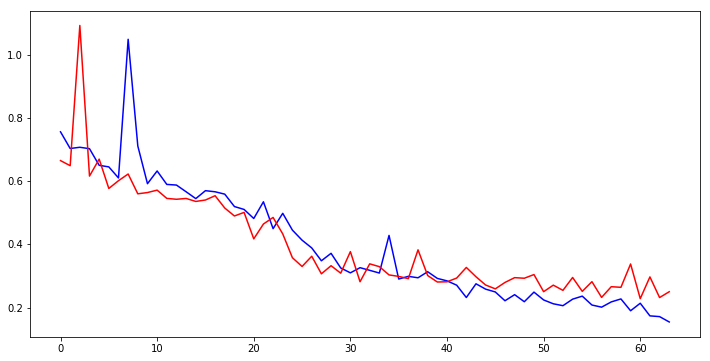

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='red')

## Step 8: Evaluate Model

In [19]:
model = load_model('checkpoint_061_0.23.hdf5')
model.save('model_02284.h5')

In [20]:
imgen_train = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True
)

imgen_valid = ImageDataGenerator()

imgen_train.fit(X_train_scaled)
imgen_valid.fit(X_valid_scaled)

E:\InstalledSoftware\Anaconda3\lib\site-packages\keras\preprocessing\image.py:683: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (1443, 75, 75, 2) (2 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')
E:\InstalledSoftware\Anaconda3\lib\site-packages\keras\preprocessing\image.py:683: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (161, 75, 75, 2) (2 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


## Step 9: Predict Model

In [21]:
def predict():
    print('> Predicting test data')
    y_pred = model.predict(X_test_scaled)
    print('> Writing submission file')
    with open('submission5.csv', 'w') as f:
        f.write('id,is_iceberg\n')
        for id_, pred in zip(ids_test, y_pred):
            f.write('{},{}\n'.format(id_, pred[0]))

predict()

> Predicting test data
> Writing submission file


## Step 10: Create submission file

In [22]:
submission = pd.read_csv('submission5.csv')
submission

,id,is_iceberg
0,5941774d,2.899770e-01
1,4023181e,7.820368e-02
2,b20200e4,0.000000e+00
3,e7f018bb,9.997376e-01
4,4371c8c3,1.441639e-14
5,a8d9b1fd,0.000000e+00
6,29e7727e,2.153206e-02
7,92a51ffb,9.999452e-01
8,c769ac97,4.040331e-25
9,aee0547d,7.606614e-38
